# Dynamic Mode Decomposition (DMD)
### *~1 year of 6-hourly data of global windspeeds from ERA5*

In [ ]:
from ipyparallel import Client
rc = Client(profile="default")
rc.ids

if len(rc.ids) == 0:
    print("No engines found")
else:
    print(f"{len(rc.ids)} engines found")

In [ ]:
%%px
import heat as ht

## Preprocessing 

The following steps have already been described in the notebook on loading and preprocessing: 

In [ ]:
%%px
u = ht.load("/projects/HPDAGrundlagensoftware-Heat/Testdata/ERA5/10m_wind_2024_every6hours.nc", "u10", device="cpu", split=0)
v = ht.load("/projects/HPDAGrundlagensoftware-Heat/Testdata/ERA5/10m_wind_2024_every6hours.nc", "v10", device="cpu", split=0)
n_timesteps, n_lon, n_lat = u.shape
w = ht.stack([u,v],axis=-1)


(1464, 721, 1440)

In order to apply Dynamic Mode Decomposition, we need to reshape the data such that there is a single feature-axis; consequently, the two components of windspeed at every location on earth need to be reshaped into a single data vector (for every time step). Moreover, DMD requires the time axis to be the second one and the feature axis the first one. This is done as follows:  

In [ ]:
%%px
w = ht.reshape(w, (n_timesteps, n_lon * n_lat * 2)).T 
w.shape, w.split 

((2076480, 1464), None)

In order to be able to execute the computations within DMD efficiently, splitting along the feature axis is desirable. Changing the split from one axis to another can be done as follows: 

In [ ]:
%%px
w.resplit_(0) 
w.split

0

Please note that, in general, a resplit operation is expensive and should be avoided if not necessary. However, in the present case it is necessary. 

## Explore low-rank structure 

To check whether application of DMD is reasonable, we first check whether there is some kind of low-rank structure in the data. 

In [ ]:
%%px
from heat.decomposition import PCA 
pca = PCA(svd_solver="full") 
pca.fit(w) 

PCA({
    "n_components": null,
    "copy": true,
    "whiten": false,
    "svd_solver": "full",
    "tol": null,
    "iterated_power": 0,
    "n_oversamples": 10,
    "power_iteration_normalizer": "qr",
    "random_state": null
})

In [ ]:
%%px
ht.norm(pca.singular_values_[1000:])/ht.norm(pca.singular_values_)

DNDarray(0.1008, dtype=ht.float32, device=cpu:0, split=None)

# Dynamic Mode Decomposition (DMD)

Although the data are not really low-rank, we proceed with computing the DMD for demonstration purposes. 

In [ ]:
%%px
from heat.decomposition import DMD 
dmd = DMD(svd_solver="full", svd_rank=1000) 
dmd.fit(w) 

Once DMD is computed, you can check the eigenvalues in order to get an impression of stability/instability of the dynamical system. 

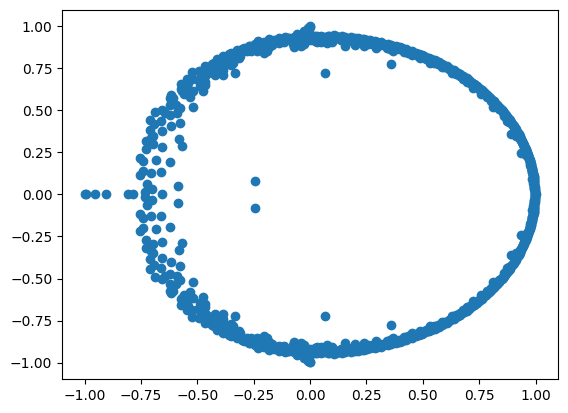

In [ ]:
%%px
dmd.rom_eigenvalues_
re,im = dmd.rom_eigenvalues_.numpy().real, dmd.rom_eigenvalues_.numpy().imag
plt.figure()
plt.scatter(re,im)
plt.show()

Moreover, you can plot the so-called DMD-modes. Of course, for plotting the reshapes done above must be undone first. 

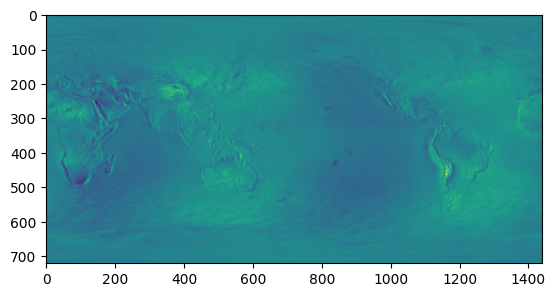

In [ ]:
%%px
first_mode_u_re = ht.real(dmd.dmdmodes_[:,0].reshape(n_lon,n_lat,2)[:,:,0])

plt.figure()
plt.imshow(first_mode_u_re.numpy())
plt.show()